# Plots
Based on the results from the notebooks:
- `experiments_homogeneous.ipynb`
- `experiments_heterogeneous.ipynb`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import string
import pandas as pd
import numpy as np
from scipy.stats import poisson
# reading
import re
import os
from pathlib import Path
from glob import glob

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns 
from matplotlib.lines import Line2D

# local
import sys
sys.path.append('../src/')
from utils.graphtool_reader import import_graphtool_network, to_undirected
from utils.simulation_helpers import load_experiment
import theoretical_boundaries as bd
from incentives_mechanism import p_incentives, p_incentives_inv
from oracle_probabilities import prob_successful_hire, prob_successful_hire_approx

In [3]:
# Some plotting parameters
import matplotlib as mpl
# font sizes
font_scaling = 1.3
title_font_size = 17 * font_scaling
label_font_size = 16 * font_scaling
tick_font_size = 13 * font_scaling
legend_font_size = 13 * font_scaling
# set font sizes
mpl.rcParams['axes.titlesize'] = title_font_size
mpl.rcParams['axes.labelsize'] = label_font_size
mpl.rcParams['xtick.labelsize'] = tick_font_size
mpl.rcParams['ytick.labelsize'] = tick_font_size
mpl.rcParams['legend.fontsize'] = legend_font_size

# plot params
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.axisbelow'] = True
figsize = (8, 6)

# Some nice plotting colors
cs = [
    "#4169E1",  # Royal Blue
    "#DC143C",  # Crimson
    "#228B22",  # Forest Green
    "#FF8C00",  # Dark Orange
    "#800080",  # Purple
    "#008080",  # Teal
    "#808000",  # Olive
    "#708090",  # Slate Gray
    "#FF1493",  # Deep Pink
    "#8B0000"   # Dark Red
]

In [4]:
## Global parameters
# Network
N = 2000
K_AVG = 20

# Oracle
ORACLE_REACH = 0.5
ORACLE_DEGREE = round(N * ORACLE_REACH)

# IHC (homogeneous)
P_RECOMMENDATION = 0.1
P_APPLICATION = 0.25 # same as Milgram's dropout rate
P_HIRING = 0.1

# IHC (with skills)
AVG_SKILLS = 3
CIs = [0.5, 0.9, 0.99] # confidence intervals
VACANCY_REQUIREMENTS = [int(poisson.interval(CI, AVG_SKILLS)[1]) for CI in CIs] # [4,6,8]

# Homophily and skill correlations
ALPHA = 0.5 # Dirichlet param. for correlated skills (0.1 => very correlated, 5 => very uncorrelated)
N_SKILL_GROUPS = 3
HOMOPHILY = 6 # (1 => low homophily, 6 => high homophily, np.inf => extreme homophily)

# Real networks
REAL_NETWORK_SELECTION = [
    "copenhagen/sms", # directed, phone sms, n=568, <k>=2.4
    "uni_email", # directed, email exchanges, n=1.1k, m=10k
    "twitter_15m", # directed, followerships, n=87k, m=6M
]

# other
DIAGNOSIS_VARS = ['chain_depths', 'applicants', 'success_rate' ] # chain_size, homophilic_hire
DIAGNOSIS_VARS_HOMOPH = DIAGNOSIS_VARS + ['homophilic_hire']
PATH = '../results/data/'
PATH_SAVE = '../results/figures/'
SAVE = False

In [6]:
# Reading and plotting helpers
def label_panels(axes, fontsize=20, labels=None, pos=(0.02, 0.98), overrides=None,
                 ha='left', va='top', fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, pad=0.2),
                 **text_kw):

    # --- normalize axes to a flat list ---
    if isinstance(axes, dict):
        axes = list(axes.values())
    elif hasattr(axes, 'ravel'):
        axes = axes.ravel().tolist()
    elif isinstance(axes, (list, tuple)):
        axes = list(axes)
    else:
        axes = [axes]

    # labels
    if labels is None:
        import string
        labels = list(string.ascii_uppercase[:len(axes)])

    for i, (a, lab) in enumerate(zip(axes, labels)):
        x, y = (overrides.get(i, (pos)) if overrides else pos)
        a.text(x, y, str(lab), transform=a.transAxes,
               ha=ha, va=va, fontsize=fontsize, fontweight=fontweight,
               bbox=bbox, clip_on=False, zorder=10, **text_kw)


def extract_param_from_path(path, param):
    """
    Extracts the value of `param` from filenames like:
    prefix-param_1=42-param_2=0.5-param_3=hello.npy
    Stops only at '-' or at the explicit '.npy' ending.
    Returns int, float, or str.
    """
    filename = Path(path).name
    # Capture anything except '-' until the next '-' OR the explicit '.npy' end
    pattern = rf"{re.escape(param)}=([^-]+?)(?=-|\.npy$)"
    m = re.search(pattern, filename)
    if not m:
        return None
    val = m.group(1)
    # Cast to int/float when possible
    try:
        return int(val)
    except ValueError:
        try:
            return float(val)
        except ValueError:
            return val

def read_results(path, diagnosis_vars=DIAGNOSIS_VARS, secondary_param=None):
    """Reads results from the given paths from the given diagnosis variables."""
    results = dict()
    for diag in diagnosis_vars:        
        results[diag] = dict()
        path_experiments = glob( os.path.join(path, diag, '*.npy') )
        if len(path_experiments) > 1:
            for p in path_experiments:
                param = extract_param_from_path(p, secondary_param)
                Z, x, y = load_experiment(p) # experiments, x-variable-range, y-variable-range
                results[diag][param] = Z
        else:        
            Z, x, y = load_experiment(path_experiments[0])
            results[diag] = Z            
    return results, x, y

# other helpers
def results_to_dataframe(
    results,
    x=None, x_name="$p_r$",
    y_name="y", col_name="requirements",                   
    system=None, system_name="system",
    col_labels=VACANCY_REQUIREMENTS
):
    """Converts the results matrix into a long/tidy DataFrame for easy seaborn plotting.
    """
    results = np.asarray(results)
    N, K = results.shape
    if x is None:
        x = np.arange(N)
    if col_labels is None:
        col_labels = list(range(K))

    wide = pd.DataFrame(results, columns=col_labels)
    wide[x_name] = x
    if system is not None:
        wide[system_name] = system

    id_vars = [x_name] + ([system_name] if system is not None else [])
    return wide.melt(id_vars=id_vars, var_name=col_name, value_name=y_name)

def direct_recs_theoretical_success_rate(n, vacancy_reqs=VACANCY_REQUIREMENTS, avg_skills=AVG_SKILLS, network_name=None, n_pr=100, n_max=10_000):
    """Computes the theoretical success rate of the direct-recommender system given:
        - n: number of nodes
        - vacancy_reqs: list of number of vacancy requirements
        - avg_skills: avg number of skills of agents
        - network_name (default = None): if given, reads the network grom graphtool and overrides `n`
        - n_pr: number of p_r values to compute the curve
        - n_max: threshold for exact vs approximate curve
    """
    # network
    if network_name is not None:
        edgelist, nodelist = import_graphtool_network(network_name.replace('-','/'))
        n = len(nodelist)
    m = round(n * ORACLE_REACH)

    # success rate line
    prs = np.linspace(0,1, n_pr)
    success_rates = []
    for nν in vacancy_reqs:
        if n > n_max:
            success_rates.append( [ prob_successful_hire_approx(n,m,pr,avg_skills,nν) for pr in prs ] )    
        else:
            success_rates.append( [ prob_successful_hire(n,m,pr,avg_skills,nν) for pr in prs ] )    
    return prs, np.array(success_rates).T

In [7]:
## GLOBAL PARAMETERS 
λ = 3
N = 5000

In [9]:
pwd

'/Users/blaskolic/Research/ResearchProjects/Incentivized Network Dynamics/independent_halting_cascades/notebooks'

In [8]:
%%time
# Parameters
λ = 3
k_avg1 = 20
k_avg2 = 50
n_sims1 = 1000
n_sims2 = 2500
n_sims3 = 100
n_nodes = 5000
p_hir1 = 1.0
p_hir2 = 0.5
p_hir3 = 0.1
p_r = 0.1
ρ_o = 0.5

# Filenames
suffix_s = '_lambda={}_kavg={}_n_sims={}_ER_n_nodes={}'.format( λ, k_avg1, n_sims1, n_nodes )
suffix_o = '_lambda={}_rho={}_n_sims={}_ER_n_nodes={}'.format( λ, ρ_o , n_sims1, n_nodes )
suffix_r = '_lambda={}_pr={}_n_sims={}_ER_n_nodes={}'.format( λ, p_r, n_sims2, n_nodes )
suffix_p1 = '_p_h={}_n_sims={}_ER_n_nodes={}_kavg={}'.format( p_hir1, n_sims3, n_nodes, k_avg2 )
suffix_p2 = '_p_h={}_n_sims={}_ER_n_nodes={}_kavg={}'.format( p_hir2, n_sims3, n_nodes, k_avg2 )
suffix_p3 = '_p_h={}_n_sims={}_ER_n_nodes={}_kavg={}'.format( p_hir3, n_sims3, n_nodes, k_avg2 )

filenames = [    
    '../
    '../outputs/data/homogeneous/social_chain_depths'+suffix_s,
    '../outputs/data/homogeneous/oracle_chain_depths'+suffix_o,
    '../outputs/data/homogeneous/social_chain_depths'+suffix_r,
    '../outputs/data/homogeneous/oracle_chain_depths'+suffix_r,
    '../outputs/data/homogeneous/social_is_hired'+suffix_s,
    '../outputs/data/homogeneous/oracle_is_hired'+suffix_o,
    '../outputs/data/homogeneous/social_is_hired'+suffix_r,
    '../outputs/data/homogeneous/oracle_is_hired'+suffix_r,
    '../outputs/data/homogeneous/social_num_applicants'+suffix_s,
    '../outputs/data/homogeneous/oracle_num_applicants'+suffix_o,
    '../outputs/data/homogeneous/social_num_applicants'+suffix_r,
    '../outputs/data/homogeneous/oracle_num_applicants'+suffix_r,
    
    '../outputs/data/oracle/ihcm_chain_depths'+suffix_p1,
    '../outputs/data/oracle/ihcm_chain_depths'+suffix_p2,
    '../outputs/data/oracle/ihcm_chain_depths'+suffix_p3,
    '../outputs/data/oracle/ihcm_chain_is_hired'+suffix_p1,
    '../outputs/data/oracle/ihcm_chain_is_hired'+suffix_p2,
    '../outputs/data/oracle/ihcm_chain_is_hired'+suffix_p3,
    '../outputs/data/oracle/ihcm_chain_applicants_reach'+suffix_p1,        
    '../outputs/data/oracle/ihcm_chain_applicants_reach'+suffix_p2,    
    '../outputs/data/oracle/ihcm_chain_applicants_reach'+suffix_p3,

    '../outputs/data/BA/ ihcm_chain_depths'+suffix_p1,
    '../outputs/data/oracle/ihcm_chain_depths'+suffix_p2,
    '../outputs/data/oracle/ihcm_chain_depths'+suffix_p3,
    '../outputs/data/oracle/ihcm_chain_is_hired'+suffix_p1,
    '../outputs/data/oracle/ihcm_chain_is_hired'+suffix_p2,
    '../outputs/data/oracle/ihcm_chain_is_hired'+suffix_p3,
    '../outputs/data/oracle/ihcm_chain_applicants_reach'+suffix_p1,        
    '../outputs/data/oracle/ihcm_chain_applicants_reach'+suffix_p2,    
    '../outputs/data/oracle/ihcm_chain_applicants_reach'+suffix_p3,
]

# Reading
data_vec = []
for filename in filenames:
    with open(filename+'.json', 'r') as f:
        data = json.load(f)
        data = convert_keys_to_numbers(data)
        data_vec.append( data )

# Naming
results_social_depths_varying_pr = data_vec[0]
results_oracle_depths_varying_pr = data_vec[1]
results_social_depths_varying_k = data_vec[2]
results_oracle_depths_varying_rho = data_vec[3]
results_social_hiring_varying_pr = data_vec[4]
results_oracle_hiring_varying_pr = data_vec[5]
results_social_hiring_varying_k = data_vec[6]
results_oracle_hiring_varying_rho = data_vec[7]
results_social_applicants_varying_pr = data_vec[8]
results_oracle_applicants_varying_pr = data_vec[9]
results_social_applicants_varying_k = data_vec[10]
results_oracle_applicants_varying_rho = data_vec[11]
results_ihcm_depths_params_ph1 = data_vec[12]
results_ihcm_depths_params_ph2 = data_vec[13]
results_ihcm_depths_params_ph3 = data_vec[14]
results_ihcm_hiring_params_ph1 = data_vec[15]
results_ihcm_hiring_params_ph2 = data_vec[16]
results_ihcm_hiring_params_ph3 = data_vec[17]
results_ihcm_applicants_params_ph1 = data_vec[18]
results_ihcm_applicants_params_ph2 = data_vec[19]
results_ihcm_applicants_params_ph3 = data_vec[20]

print(len(data_vec))
del data_vec

FileNotFoundError: [Errno 2] No such file or directory: '../outputs/data/homogeneous/social_chain_depths_lambda=3_kavg=20_n_sims=1000_ER_n_nodes=5000.json'

In [8]:
%%time
# Parameters
λ = 3
k_avg1 = 20
k_avg2 = 50
n_sims1 = 1000
n_sims2 = 2500
n_sims3 = 100
n_nodes = 5000
p_hir1 = 1.0
p_hir2 = 0.5
p_hir3 = 0.1
p_r = 0.1
ρ_o = 0.5

# Filenames
suffix_s = '_lambda={}_kavg={}_n_sims={}_ER_n_nodes={}'.format( λ, k_avg1, n_sims1, n_nodes )
suffix_o = '_lambda={}_rho={}_n_sims={}_ER_n_nodes={}'.format( λ, ρ_o , n_sims1, n_nodes )
suffix_r = '_lambda={}_pr={}_n_sims={}_ER_n_nodes={}'.format( λ, p_r, n_sims2, n_nodes )
suffix_p1 = '_p_h={}_n_sims={}_ER_n_nodes={}_kavg={}'.format( p_hir1, n_sims3, n_nodes, k_avg2 )
suffix_p2 = '_p_h={}_n_sims={}_ER_n_nodes={}_kavg={}'.format( p_hir2, n_sims3, n_nodes, k_avg2 )
suffix_p3 = '_p_h={}_n_sims={}_ER_n_nodes={}_kavg={}'.format( p_hir3, n_sims3, n_nodes, k_avg2 )

filenames = [    
    '../
    '../outputs/data/homogeneous/social_chain_depths'+suffix_s,
    '../outputs/data/homogeneous/oracle_chain_depths'+suffix_o,
    '../outputs/data/homogeneous/social_chain_depths'+suffix_r,
    '../outputs/data/homogeneous/oracle_chain_depths'+suffix_r,
    '../outputs/data/homogeneous/social_is_hired'+suffix_s,
    '../outputs/data/homogeneous/oracle_is_hired'+suffix_o,
    '../outputs/data/homogeneous/social_is_hired'+suffix_r,
    '../outputs/data/homogeneous/oracle_is_hired'+suffix_r,
    '../outputs/data/homogeneous/social_num_applicants'+suffix_s,
    '../outputs/data/homogeneous/oracle_num_applicants'+suffix_o,
    '../outputs/data/homogeneous/social_num_applicants'+suffix_r,
    '../outputs/data/homogeneous/oracle_num_applicants'+suffix_r,
    
    '../outputs/data/oracle/ihcm_chain_depths'+suffix_p1,
    '../outputs/data/oracle/ihcm_chain_depths'+suffix_p2,
    '../outputs/data/oracle/ihcm_chain_depths'+suffix_p3,
    '../outputs/data/oracle/ihcm_chain_is_hired'+suffix_p1,
    '../outputs/data/oracle/ihcm_chain_is_hired'+suffix_p2,
    '../outputs/data/oracle/ihcm_chain_is_hired'+suffix_p3,
    '../outputs/data/oracle/ihcm_chain_applicants_reach'+suffix_p1,        
    '../outputs/data/oracle/ihcm_chain_applicants_reach'+suffix_p2,    
    '../outputs/data/oracle/ihcm_chain_applicants_reach'+suffix_p3,

    '../outputs/data/BA/ihcm_chain_depths'+suffix_p1,
    '../outputs/data/oracle/ihcm_chain_depths'+suffix_p2,
    '../outputs/data/oracle/ihcm_chain_depths'+suffix_p3,
    '../outputs/data/oracle/ihcm_chain_is_hired'+suffix_p1,
    '../outputs/data/oracle/ihcm_chain_is_hired'+suffix_p2,
    '../outputs/data/oracle/ihcm_chain_is_hired'+suffix_p3,
    '../outputs/data/oracle/ihcm_chain_applicants_reach'+suffix_p1,        
    '../outputs/data/oracle/ihcm_chain_applicants_reach'+suffix_p2,    
    '../outputs/data/oracle/ihcm_chain_applicants_reach'+suffix_p3,
]

# Reading
data_vec = []
for filename in filenames:
    with open(filename+'.json', 'r') as f:
        data = json.load(f)
        data = convert_keys_to_numbers(data)
        data_vec.append( data )

# Naming
results_social_depths_varying_pr = data_vec[0]
results_oracle_depths_varying_pr = data_vec[1]
results_social_depths_varying_k = data_vec[2]
results_oracle_depths_varying_rho = data_vec[3]
results_social_hiring_varying_pr = data_vec[4]
results_oracle_hiring_varying_pr = data_vec[5]
results_social_hiring_varying_k = data_vec[6]
results_oracle_hiring_varying_rho = data_vec[7]
results_social_applicants_varying_pr = data_vec[8]
results_oracle_applicants_varying_pr = data_vec[9]
results_social_applicants_varying_k = data_vec[10]
results_oracle_applicants_varying_rho = data_vec[11]
results_ihcm_depths_params_ph1 = data_vec[12]
results_ihcm_depths_params_ph2 = data_vec[13]
results_ihcm_depths_params_ph3 = data_vec[14]
results_ihcm_hiring_params_ph1 = data_vec[15]
results_ihcm_hiring_params_ph2 = data_vec[16]
results_ihcm_hiring_params_ph3 = data_vec[17]
results_ihcm_applicants_params_ph1 = data_vec[18]
results_ihcm_applicants_params_ph2 = data_vec[19]
results_ihcm_applicants_params_ph3 = data_vec[20]

print(len(data_vec))
del data_vec

FileNotFoundError: [Errno 2] No such file or directory: '../outputs/data/homogeneous/social_chain_depths_lambda=3_kavg=20_n_sims=1000_ER_n_nodes=5000.json'

In [7]:
%%time
## PARAMETER ARRAY INFERENCE FROM RESULTS DICTIONARIES

## Grid-based
# grid of application and activation probabilities
p_acts = [float(s[6:]) for s in results_ihcm_applicants_params_ph1.keys()]
p_apps = [float(s[6:]) for s in results_ihcm_applicants_params_ph1[f'p_act={p_acts[0]}'].keys()]

## Model-comparison-based
# Confidence intervals for vacancy specificities
CIs = list(results_social_depths_varying_k.keys())
# average number of connections per node array
k_avgs = [ float(ci) for ci in results_social_depths_varying_k[CIs[0]].keys()]
# Oracle reach array
ρ_os = [ float(ci) for ci in results_oracle_depths_varying_rho[CIs[0]].keys()]
# activation/recommendation probability array
p_rs = [ float(ci) for ci in results_social_depths_varying_pr[CIs[0]].keys()]

CPU times: user 26 µs, sys: 0 ns, total: 26 µs
Wall time: 27.2 µs


In [130]:
## Read analytic results for oracle hiring probabilities
oracle_probas_analytic_varying_rho = pd.read_csv( '../outputs/oracle_probas_analytic_varying_rho.csv', index_col=0 )
oracle_probas_analytic_weighted_varying_rho = pd.read_csv( '../outputs/oracle_probas_analytic_weighted_varying_rho.csv', index_col=0 )
oracle_probas_analytic_weighted_varying_pr = pd.read_csv( '../outputs/oracle_probas_analytic_weighted_varying_pr.csv', index_col=0 )
oracle_probas_analytic_weighted_varying_rho2 = pd.read_csv( '../outputs/oracle_probas_analytic_weighted_varying_rho2.csv', index_col=0 )
oracle_probas_analytic_weighted_varying_pr2 = pd.read_csv( '../outputs/oracle_probas_analytic_weighted_varying_pr2.csv', index_col=0 )
oracle_probas_analytic_varying_pr = pd.read_csv( '../outputs/oracle_probas_analytic_varying_pr.csv', index_col=0 )
CIs_to_spec = dict(zip( CIs, [4,6,8]  ))

# Figure 1
Homogeneous ER parameter grid

In [7]:
# read 
path = os.path.join( PATH, 'homogeneous', 'grid', 'ER' )
results, p_recs, p_apps = read_results(path, secondary_param='ph')

# save params
path_save = os.path.join( PATH_SAVE, 'homogeneous', 'grid', 'ER' )
os.makedirs(path_save, exist_ok=True)

# secondary param
phs = [0.1, 0.5, 1]
print("Read successfully!")

Read successfully!


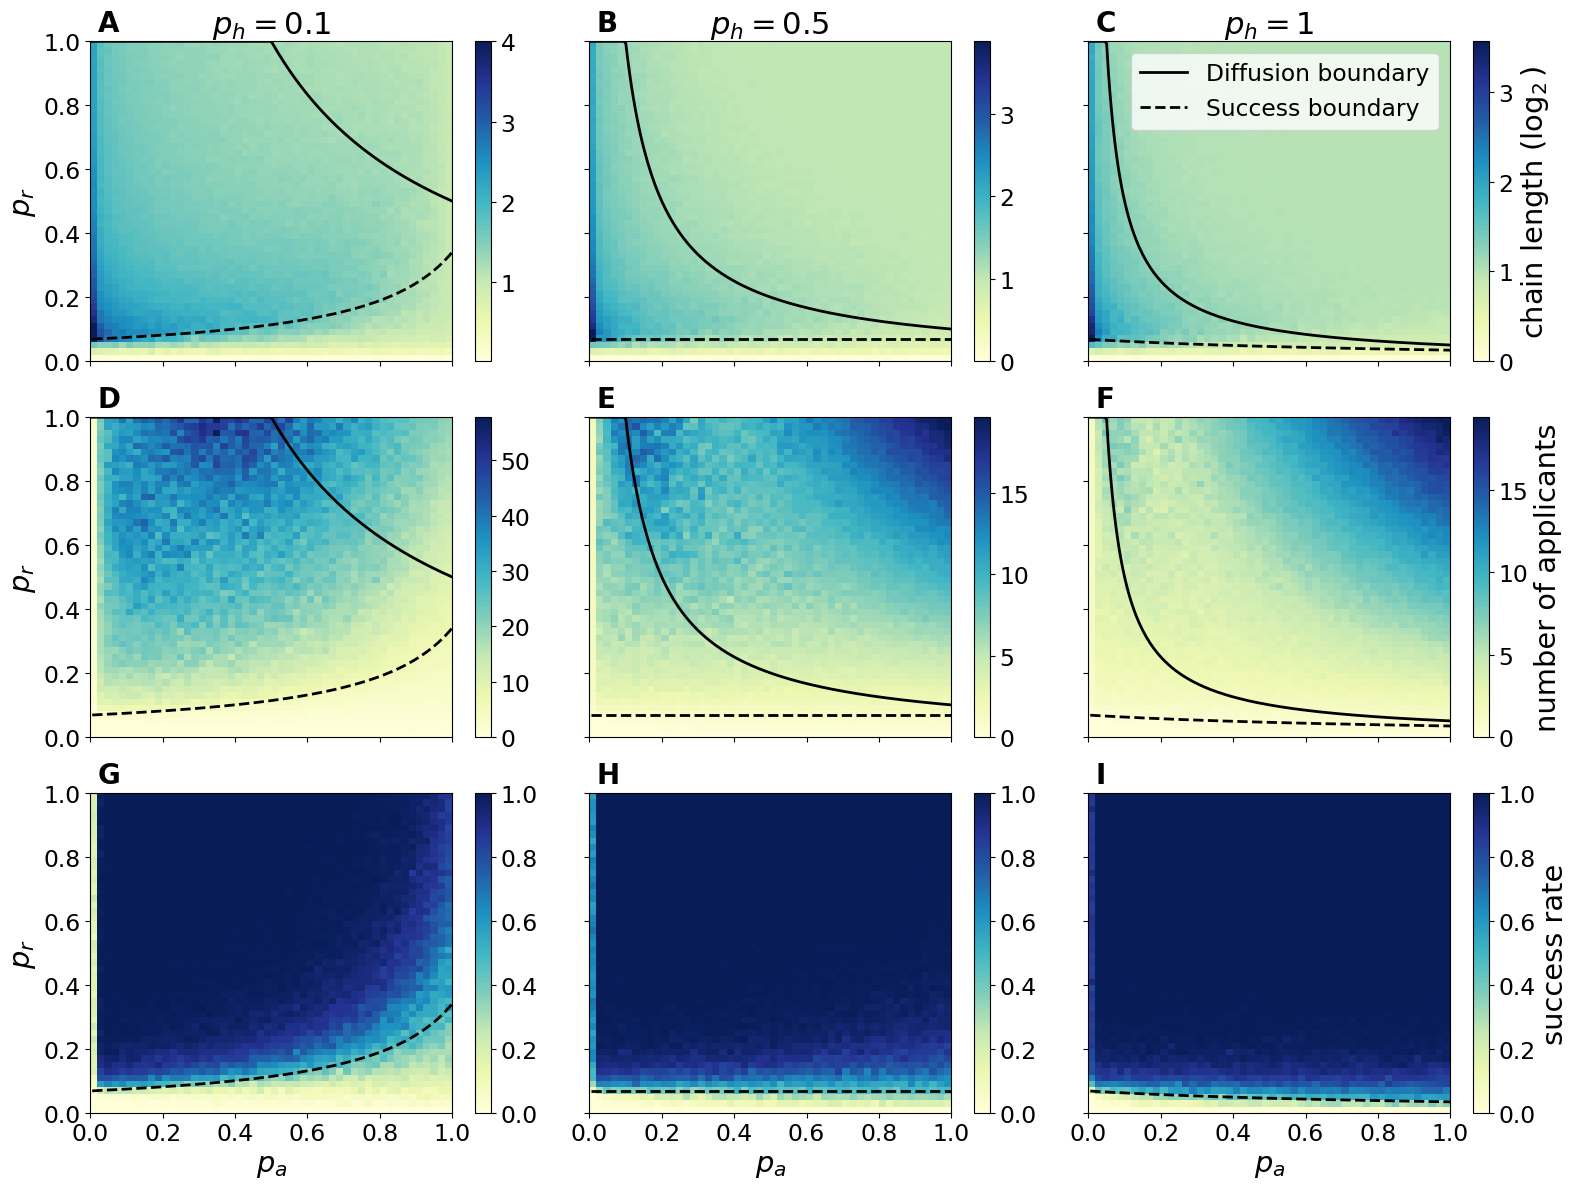

In [8]:
# global plot params
fig, axes = plt.subplots(3, 3, figsize=(2*figsize[0], 2*figsize[1]),
                         sharex=True, sharey=True)

q = 0.5 # curve quantile for success boundaries
for col, ph in enumerate(phs):
    ax = axes[:,col] 

    ## Prepare data
    depths = np.mean(results['chain_depths'][ph], axis=1).reshape( len(p_recs), len(p_apps) )
    applicants = np.mean(results['applicants'][ph], axis=1).reshape( len(p_recs), len(p_apps) )
    success = np.mean(results['success_rate'][ph], axis=1).reshape( len(p_recs), len(p_apps) )
    ## Prepare boundaries    
    pa_boundary, pr_boundary_diffusion = bd.diffusion_boundary_contour_pr(ph, K_AVG) # diffusion boundary    
    pa_boundary, pr_boundary_failure = bd.success_contour_at_prob_tau(ph, K_AVG, tau=q) # success boundary

    ## Viz    
    # ========== PLOT 1 (chain length) ==========    
    heatmap = ax[0].imshow(np.log2(depths), cmap="YlGnBu", extent=[0,1,0,1], label='', aspect='auto', origin='upper')
    cbar = fig.colorbar(heatmap, ax=ax[0])
    if col == len(phs)-1: # just in right-most plot
        cbar.set_label("chain length ($\log_2$)")
    # plot boundaries    
    ax[0].plot(pa_boundary, pr_boundary_diffusion, color='black', ls='-', lw=2, label='Diffusion boundary')
    ax[0].plot(pa_boundary, pr_boundary_failure, color='black', ls='--', lw=2, label='Success boundary')

    # ========== PLOT 2 (applicants) ==========    
    heatmap = ax[1].imshow(applicants, cmap="YlGnBu", extent=[0,1,0,1], label='', aspect='auto', origin='upper')
    cbar = fig.colorbar(heatmap, ax=ax[1])
    if col == len(phs)-1: # just in right-most plot
        cbar.set_label("number of applicants")
    # plot boundaries        
    ax[1].plot(pa_boundary, pr_boundary_diffusion, color='black', ls='-', lw=2, label='Diffusion boundary')
    ax[1].plot(pa_boundary, pr_boundary_failure, color='black', ls='--', lw=2, label='Success boundary')

    # ========== PLOT 3 (success rate) ==========    
    heatmap = ax[2].imshow(success, cmap="YlGnBu", extent=[0,1,0,1], label='', aspect='auto', origin='upper')
    cbar = fig.colorbar(heatmap, ax=ax[2])
    if col == len(phs)-1: # just in right-most plot
        cbar.set_label("success rate")
    # plot boundaries        
    # ax[2].plot(pa_boundary, pr_boundary_diffusion, color='black', ls='-', label='Diffusion boundary')
    ax[2].plot(pa_boundary, pr_boundary_failure, color='black', ls='--', lw=2, label='Success boundary')    

# Plot single legend
h, l = axes[0,-1].get_legend_handles_labels()
axes[0,-1].legend(h, l)

# label axes and titles
[ axes[0,i].set_title(f"$p_h = {ph}$") for i,ph in enumerate(phs) ]
[ axes[-1,i].set_xlabel("$p_a$") for i in range(axes.shape[1]) ]
[ axes[i,0].set_ylabel("$p_r$") for i in range(axes.shape[0]) ]

## Add panel labels
label_panels(axes, pos=(0.02, 1.1))

plt.tight_layout()    
    
# # Save the figure
if SAVE:
    fn = f'n_nodes={N}-k_avg={K_AVG}.png'
    fn = os.path.join(path_save, fn)
    plt.savefig(fn, format='png', dpi=300, bbox_inches='tight')
    print(f"Plot saved successfully at {fn}")

# Figure 2
Effect of incentives

In [9]:
# read 
path = os.path.join( PATH, 'homogeneous', 'incentives', 'ER' )
results, p_recs, betas = read_results(path)

# save params
path_save = os.path.join( PATH_SAVE, 'homogeneous', 'incentives', 'ER' )
os.makedirs(path_save, exist_ok=True)

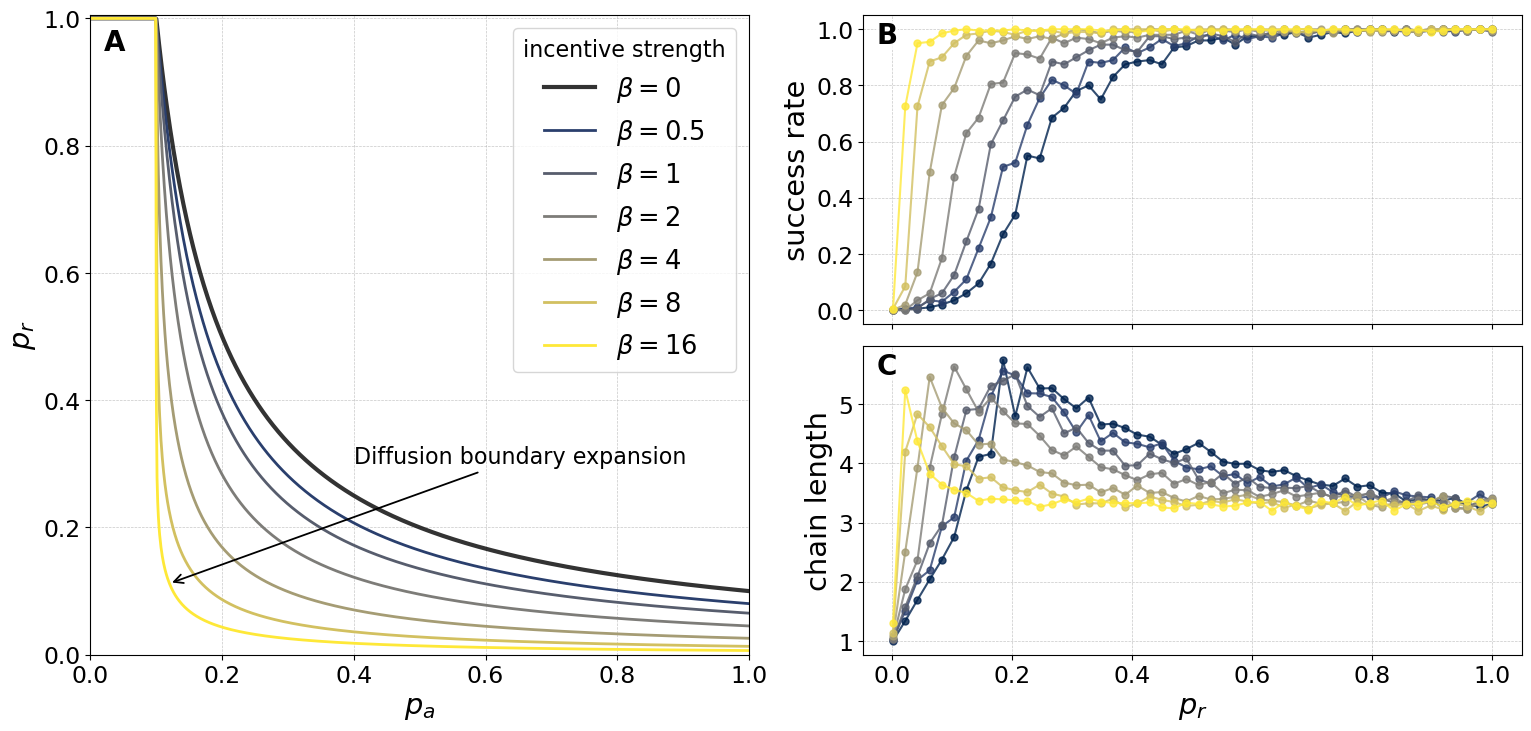

In [10]:
## Prepare data
successes  = np.mean(results['success_rate'], axis=1).reshape( len(p_recs), len(betas) )
depths     = np.mean(results['chain_depths'], axis=1).reshape( len(p_recs), len(betas) )
applicants = np.mean(results['applicants'], axis=1).reshape( len(p_recs), len(betas) )
# Diffusion boundary
ph, fv = 0.5, 1.0 # halting prob, v's fittness
pa, pr_diff = bd.diffusion_boundary_contour_pr(ph, K_AVG, 1000)


## Viz
fig, ax = plt.subplot_mosaic(
    [['C','A'],
     ['C','B']],
    figsize=(1.9*figsize[0], 1.2*figsize[1]), constrained_layout=True,    
)
cmap = plt.get_cmap('cividis', len(betas))

# ========== PLOT 1 (success) ==========
# Plot data for different incentives strength β
for i in range(len(betas)):
    ax['A'].plot(p_recs, successes[:,i], marker='o', alpha=0.8, ms=5, label=f'$\\beta = {betas[i]}$', color=cmap(i))

# plot details
ax['A'].set_ylabel("success rate",)
ax['A'].grid(True)
# ax['A'].legend(title='incentive strength', title_fontsize=14, loc='center right');

# ========== PLOT 2 (lengths) ==========
# Plot data for different incentives strength β
for i in range(len(betas)):
    ax['B'].plot(p_recs, depths[:,i], marker='o', alpha=0.8, ms=5, label=f'$\\beta = {betas[i]}$', color=cmap(i))

# plot details
ax['B'].set_xlabel("$p_r$",)
ax['B'].set_ylabel("chain length",)
ax['B'].grid(True)

# ========== PLOT 3 (boundary gain) ==========
# Plot vanilla boundary
ax['C'].plot(pa, pr_diff, ls=None, lw=3, color="black",  label='$\\beta = 0$', alpha=0.8)#, zorder=3)
# Boundaries after incentives
for i,β in enumerate(betas[1:]):
    pr_diff_β = np.clip(p_incentives_inv(pr_diff, fv, β), 0, 1)
    ax['C'].plot(pa, pr_diff_β, ls=None, lw=2, color=cmap(i+1), label=f'$\\beta ={β}$')


ax['C'].set_xlim(0, 1)
ax['C'].set_ylim(0, 1.005)
ax['C'].set_xlabel(r"$p_a$")
ax['C'].set_ylabel(r"$p_r$")
ax['C'].grid()
# text annotation
ax['C'].annotate("Diffusion boundary expansion", fontsize=16,
            xy=(0.12, np.interp(0.12, pa, pr_diff_β)), # arrow end position
            arrowprops=dict(arrowstyle="->", lw=1.3),
            xytext=(0.4, 0.30), # text position
           )
# legend
ax['C'].legend(title='incentive strength', title_fontsize=16, fontsize=legend_font_size*1.1,              
             loc='upper right')


# share x ONLY between A and B
ax['B'].sharex(ax['A'])
ax['A'].tick_params(labelbottom=False)  # hide top x labels if you like

## Add panel labels
label_panels(ax)#, pos=(0.02, 0.98), fontsize=16)

if SAVE:
    sample_path = glob( os.path.join(path, 'chain_depths', '*.npy') )[0]
    pa = extract_param_from_path(sample_path, 'pa')
    ph = extract_param_from_path(sample_path, 'ph')
    fn = f'n_nodes={N}-pa={pa}-ph={ph}.png'
    fn = os.path.join(path_save, fn)
    plt.savefig(fn, format='png', dpi=300, bbox_inches='tight')
    print(f"Plot saved successfully at {fn}")

# Figure 3
Barabasi-Albert networks and dependance of initial spreader's degree

In [11]:
# read 
path = os.path.join( PATH, 'homogeneous', 'pr_vs_k0', 'BA' )
results, p_recs, k0_ranges = read_results(path)

# save params
path_save = os.path.join( PATH_SAVE, 'homogeneous', 'pr_vs_k0', 'BA' )
os.makedirs(path_save, exist_ok=True)

## ER reading
# read 
path_er = os.path.join( PATH, 'homogeneous', 'grid', 'ER' )
results_er, p_recs_er, p_apps_er = read_results(path_er, secondary_param='ph')

print("Read successfully!")

Read successfully!


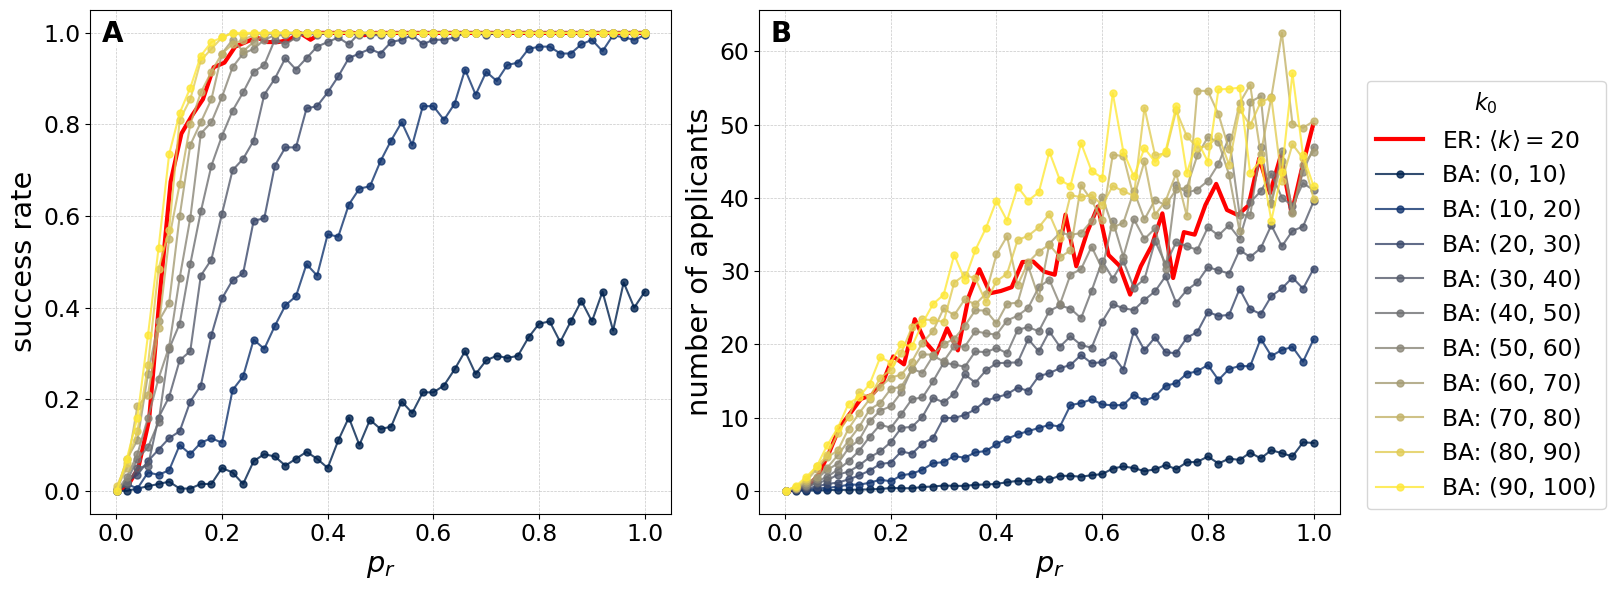

In [12]:
### DOUBLE PLOT FIGURE ### 
## Prepare data
# BA
diagnosis_var = 'success_rate'
successes = np.mean(results['success_rate'], axis=1).reshape( len(p_recs), len(k0_ranges) )
depths = np.mean(results['chain_depths'], axis=1).reshape( len(p_recs), len(k0_ranges) )
applicants = np.mean(results['applicants'], axis=1).reshape( len(p_recs), len(k0_ranges) )
# ER
pa_ix = (np.abs(p_apps_er - P_APPLICATION)).argmin() # Slice closest to pa=0.25
successes_er = np.mean(results_er['success_rate'][0.1], axis=1).reshape( len(p_recs_er), len(p_apps_er) )
depths_er = np.mean(results_er['chain_depths'][0.1], axis=1).reshape( len(p_recs_er), len(p_apps_er) )
applicants_er = np.mean(results_er['applicants'][0.1], axis=1).reshape( len(p_recs_er), len(p_apps_er) )
successes_er, depths_er, applicants_er = successes_er[:,pa_ix], depths_er[:,pa_ix], applicants_er[:,pa_ix] # restrict to pa slice

## Viz
# fig params
fig, axes = plt.subplots(1, 2, figsize=(1.7*figsize[0], figsize[1]), sharex=True)
cmap = plt.get_cmap('cividis', len(k0_ranges))

# ========== PLOT 1 ==========
ax = axes[0]
# Plot reference data for ER network k_avg=20
ax.plot(p_recs_er, successes_er, color='red', lw=3, label=f'ER: $\\langle k \\rangle = {K_AVG}$')
# Plot data for each k0 in BA network
for i in range(successes.shape[1]):
    ax.plot(p_recs, successes[:,i], marker='o', alpha=0.8, ms=5, label=f'BA: {k0_ranges[i]}', color=cmap(i))

ax.set_xlabel("$p_r$")
ax.set_ylabel("success rate")
ax.grid(True)

# ========== PLOT 2 ==========
ax = axes[1]
# Plot reference data for ER network k_avg=20
ax.plot(p_recs_er, applicants_er, color='red', lw=3, label=f'ER: $\\langle k \\rangle = {K_AVG}$')
# Plot data for each k0 in BA network
for i in range(successes.shape[1]):
    ax.plot(p_recs, applicants[:,i], marker='o', alpha=0.8, ms=5, label=f'BA: {k0_ranges[i]}', color=cmap(i))

ax.set_xlabel("$p_r$")
ax.set_ylabel("number of applicants")
ax.grid(True)

## LEGEND: Place one legend for the whole figure
h, l = axes[1].get_legend_handles_labels()
fig.legend(h,l, title='$k_0$', title_fontsize=16,
           loc='center left', bbox_to_anchor=(1., 0.5))


## Add panel labels
label_panels(axes, pos=(0.02, 0.98))

# global fig params
plt.tight_layout()
# plt.subplots_adjust(wspace=0.2);

## Save 
if SAVE:
    sample_path = glob(os.path.join(path, 'chain_depths', '*.npy'))[0]
    pa = extract_param_from_path(sample_path, 'pa')
    ph = extract_param_from_path(sample_path, 'ph')
    fn = f'success_rate-chain_depths-n_nodes={N}-pa={pa}-ph={ph}.png'
    fn = os.path.join(path_save, fn)
    plt.savefig(fn, format='png', dpi=300, bbox_inches='tight')
    print(f"Plot saved successfully at {fn}")

# Figure 4
IHC vs Oracle

In [14]:
# read 
path = os.path.join( PATH, 'heterogeneous', 'pr_vs_requirements', 'ER' )
path_oracle = os.path.join( PATH, 'heterogeneous', 'pr_vs_requirements', 'oracle' )
results, p_recs, vacancy_requirements = read_results(path)
results_oracle, p_recs, vacancy_requirements = read_results(path_oracle)

# save params
path_save = os.path.join( PATH_SAVE, 'heterogeneous', 'pr_vs_requirements', 'ER' )
path_save_oracle = os.path.join( PATH_SAVE, 'heterogeneous', 'pr_vs_requirements', 'oracle' )
os.makedirs(path_save, exist_ok=True)
os.makedirs(path_save_oracle, exist_ok=True)

print("Read successfully!")

Read successfully!


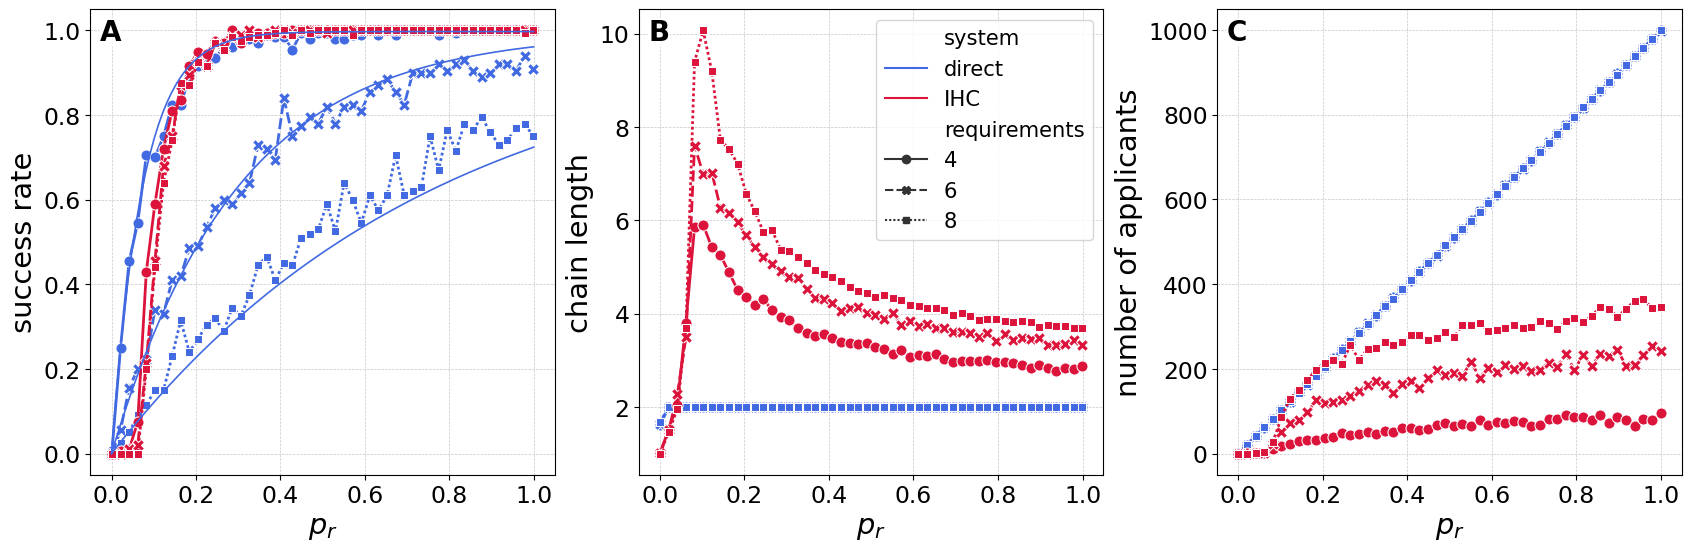

In [15]:
# global plot params
fig, ax = plt.subplots(1, 3, figsize=(2.1*figsize[0], 0.9*figsize[1]), constrained_layout=True,
                         sharex=False, sharey=False)
ax = ax.flatten() # for easy indexing 

## Prepare data    
success    = np.mean(results['success_rate'], axis=1).reshape( len(p_recs), len(vacancy_requirements) )
applicants = np.mean(results['applicants'], axis=1).reshape( len(p_recs), len(vacancy_requirements) )
depths     = np.mean(results['chain_depths'], axis=1).reshape( len(p_recs), len(vacancy_requirements) )
success_oracle    = np.mean(results_oracle['success_rate'], axis=1).reshape( len(p_recs), len(vacancy_requirements) )
applicants_oracle = np.mean(results_oracle['applicants'], axis=1).reshape( len(p_recs), len(vacancy_requirements) )
depths_oracle     = np.mean(results_oracle['chain_depths'], axis=1).reshape( len(p_recs), len(vacancy_requirements) )
## Convert to long dataframe
# success rate
df_success_ihc = results_to_dataframe(success, x=p_recs, system='IHC')
df_success_oracle = results_to_dataframe(success_oracle, x=p_recs, system='direct')
df_success = pd.concat([df_success_oracle, df_success_ihc], ignore_index=True)
# applicants
df_applicants_ihc = results_to_dataframe(applicants, x=p_recs, system='IHC')
df_applicants_oracle = results_to_dataframe(applicants_oracle, x=p_recs, system='direct')
df_applicants = pd.concat([df_applicants_oracle, df_applicants_ihc], ignore_index=True)
# chain depth
df_depths_ihc = results_to_dataframe(depths, x=p_recs, system='IHC')
df_depths_oracle = results_to_dataframe(depths_oracle, x=p_recs, system='direct')
df_depths = pd.concat([df_depths_oracle, df_depths_ihc], ignore_index=True)
## Theoretical predictions
prs_theo, success_theo = oracle_theoretical_success_rate(N)

## Viz    
# ========== PLOT 1 (success rate) ==========        
sns.lineplot(
    data=df_success, x="$p_r$", y='y', hue="system", style="requirements", 
    markers=True, dashes=True, palette=cs[:2], lw=2, ms=8, ax=ax[0], legend=False)
ax[0].plot(prs_theo, success_theo, color=cs[0], lw=1.2)

ax[0].set_ylabel('success rate')
ax[0].grid(True)

# ========== PLOT 2 (chain length) ==========        
sns.lineplot(
    data=df_depths, x="$p_r$", y='y', hue="system", style="requirements", 
    markers=True, dashes=True, palette=cs[:2], lw=2, ms=8, ax=ax[1], legend=True)
    
ax[1].set_ylabel('chain length')
ax[1].grid(True)
ax[1].legend(loc='upper right', fontsize=legend_font_size*0.9)

# ========== PLOT 3 (applicants) ==========        
sns.lineplot(
    data=df_applicants, x="$p_r$", y='y', hue="system", style="requirements", 
    markers=True, dashes=True, palette=cs[:2], lw=2, ms=8, ax=ax[2], legend=False)

ax[2].set_ylabel('number of applicants')
ax[2].grid(True)
# ax[2].legend(loc='upper left', fontsize=legend_font_size*0.9)

## Add panel labels
label_panels(ax, pos=(0.02, 0.98))

if SAVE:
    sample_path = glob(os.path.join(path, 'chain_depths', '*.npy'))[0]
    avg_skills = extract_param_from_path(sample_path, 'avg_skills')    
    fn = f'n_nodes={N}-k_avg={K_AVG}-avg_skills={avg_skills}.png'
    fn = os.path.join(path_save, fn)
    plt.savefig(fn, format='png', dpi=300, bbox_inches='tight')
    print(f"Plot saved successfully at {fn}")

# Figure 5
Homophilic networks

In [16]:
# helper
def homophilic_hires_per_chain_length(chain_depths, homophilic_hires, homophily_vals):
    """Returns homophilic hires per chain length from the results' distributions.    
    """
    assert len(chain_depths) == len(homophilic_hires)
    n_homophilies = len(homophily_vals)
    
    lengths  = [x  for idx, (di, hi) in enumerate(zip(chain_depths, homophilic_hires)) for x in di]
    hires = [b  for idx, (di, hi) in enumerate(zip(chain_depths, homophilic_hires)) for b in hi]
    homs = [idx % n_homophilies for idx, (di, hi) in enumerate(zip(chain_depths, homophilic_hires)) for _ in di]

    df = pd.DataFrame({"chain length": lengths, "hires": hires, "homs": homs})
    df = df.groupby(["chain length", "homs"])["hires"].mean().unstack("homs").sort_index()
    df.columns = homophily_vals
    return df

In [17]:
# read 
path = os.path.join( PATH, 'heterogeneous', 'pr_vs_homophily', 'homophilic' )
results, p_recs, homophilies = read_results(path, diagnosis_vars=DIAGNOSIS_VARS_HOMOPH)

# save params
path_save = os.path.join( PATH_SAVE, 'heterogeneous', 'pr_vs_homophily', 'homophilic' )
os.makedirs(path_save, exist_ok=True)

print("Read successfully!")

Read successfully!


In [18]:
depths = np.mean(results['chain_depths'], axis=1).reshape( len(p_recs), len(homophilies) )
successes = np.mean(results['success_rate'], axis=1).reshape( len(p_recs), len(homophilies) )
applicants = np.mean(results['applicants'], axis=1).reshape( len(p_recs), len(homophilies) )
homophilic_hires = np.mean(results['homophilic_hire'], axis=1).reshape( len(p_recs), len(homophilies) )

depths_succ_dist = [list(np.array(v)[b]) for v,b in zip(results['chain_depths'], results['success_rate'])]
homophilic_hire_succ_dist = [list(np.array(v)[b]) for v,b in zip(results['homophilic_hire'], results['success_rate'])]

depths_succ = np.array([np.mean(s) for s in depths_succ_dist]).reshape( len(p_recs), len(homophilies) );

/Users/blaskolic/miniconda3/envs/networks/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/blaskolic/miniconda3/envs/networks/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


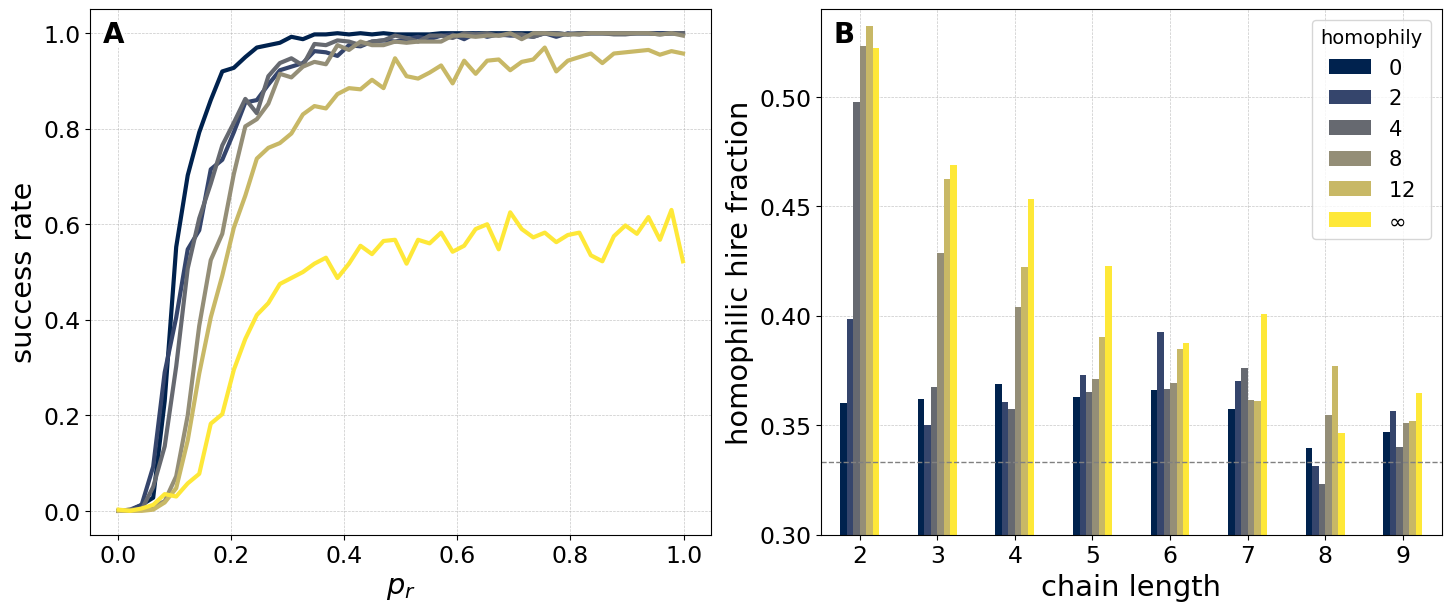

In [19]:
## Prepare data
df = homophilic_hires_per_chain_length(depths_succ_dist, homophilic_hire_succ_dist, homophilies)

## Viz
# fig params
fig, ax = plt.subplots(1, 2, figsize=(1.8*figsize[0], figsize[1]), sharex=False, constrained_layout=True)
ax = ax.flatten()
cmap = plt.get_cmap('cividis', len(homophilies))
h_labels = [str(h).replace('inf', '\\infty') for h in homophilies]
h_labels = [f"${h}$" for h in h_labels]
df.columns = h_labels

# ========== PLOT 1 (success rate) ==========
for i in range(len(homophilies)):
    ax[0].plot(p_recs, successes[:,i], lw=3, color=cmap(i))

ax[0].set_xlabel("$p_r$")
ax[0].set_ylabel("success rate")
ax[0].grid(True)

# ========== PLOT 2 (homophilic hires) ==========
df.loc[:9].plot(cmap=cmap, kind='bar', ax=ax[1])
ax[1].axhline(1/3, ls="--", lw=1, color="gray")
ax[1].set_ylim(0.3, 0.54)

ax[1].tick_params(axis='x', labelrotation=0)
ax[1].set_xlabel('chain length')
ax[1].set_ylabel('homophilic hire fraction');
ax[1].grid(True)
ax[1].legend(title='homophily', fontsize=legend_font_size*0.9, title_fontsize=14)

## Add panel labels
label_panels(ax, pos=(0.02, 0.98))

if SAVE:
    # params
    sample_path = glob(os.path.join(path, 'chain_depths', '*.npy'))[0]
    avg_skills = extract_param_from_path(sample_path, 'avg_skills')
    n_skill_groups = extract_param_from_path(sample_path, 'n_skill_groups')
    alpha = extract_param_from_path(sample_path, 'alpha')    
    # paths
    fn = f'n_nodes={N}-k_avg={K_AVG}-avg_skills={avg_skills}-n_skill_groups={n_skill_groups}-alpha={alpha}.png'
    fn = os.path.join(path_save, fn)
    # save
    plt.savefig(fn, format='png', dpi=300, bbox_inches='tight')
    print(f"Plot saved successfully at {fn}")

In [332]:
# read 
path = os.path.join( PATH, 'heterogeneous', 'alpha_vs_homophily', 'homophilic' )
results, alphas, homophilies = read_results(path, diagnosis_vars=DIAGNOSIS_VARS_HOMOPH)

# save params
path_save = os.path.join( PATH_SAVE, 'heterogeneous', 'alpha_vs_homophily', 'homophilic' )
os.makedirs(path_save, exist_ok=True)

print("Read successfully!")

Read successfully!


In [339]:
depths = np.mean(results['chain_depths'], axis=1).reshape( len(alphas), len(homophilies) )
successes = np.mean(results['success_rate'], axis=1).reshape( len(alphas), len(homophilies) )
applicants = np.mean(results['applicants'], axis=1).reshape( len(alphas), len(homophilies) )
homophilic_hires = np.mean(results['homophilic_hire'], axis=1).reshape( len(alphas), len(homophilies) )

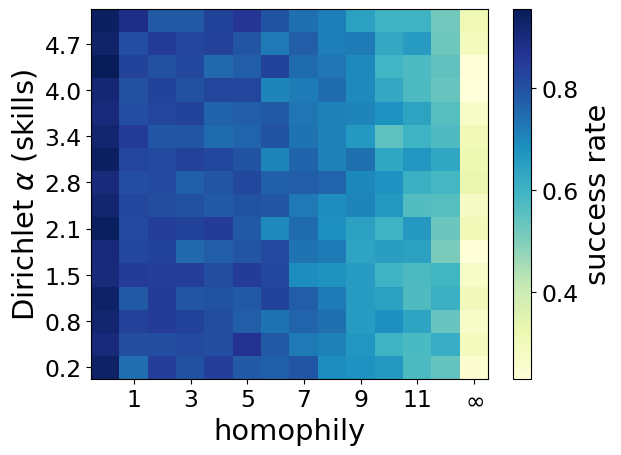

In [353]:
plt.imshow(successes , cmap="YlGnBu", aspect='auto', origin='lower')
hs = [ str(int(h)) if h != np.inf else '$\\infty$' for h in homophilies  ]
plt.xticks(range(successes.shape[1])[1::2], hs[1::2])
plt.yticks(range(successes.shape[0])[::2], alphas.round(1)[::2])
plt.xlabel('homophily')
plt.ylabel('Dirichlet $\\alpha$ (skills)')
cbar = plt.colorbar();
cbar.set_label('success rate')

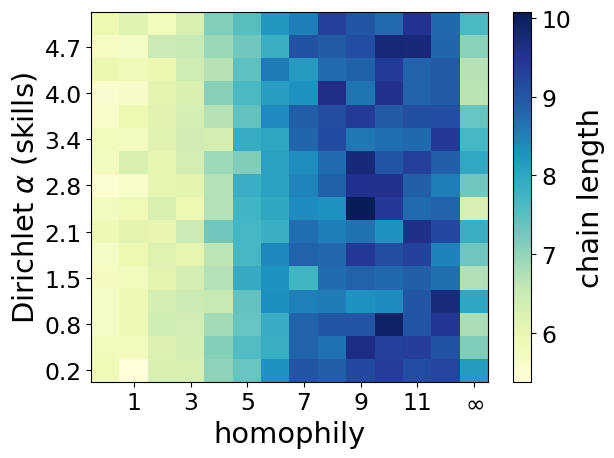

In [356]:
plt.imshow(depths, cmap="YlGnBu", aspect='auto', origin='lower')
hs = [ str(int(h)) if h != np.inf else '$\\infty$' for h in homophilies  ]
plt.xticks(range(depths.shape[1])[1::2], hs[1::2])
plt.yticks(range(depths.shape[0])[::2], alphas.round(1)[::2])
plt.xlabel('homophily')
plt.ylabel('Dirichlet $\\alpha$ (skills)')
cbar = plt.colorbar();
cbar.set_label('chain length')

# Figure 6
Reproducing empirical chains

In [20]:
# read 
path = os.path.join( PATH, 'homogeneous', 'milgram_and_dodds', 'ER' )
fn_milgram = os.path.join(path, 'Milgram-depth_distribution-emprical_vs_simulation.csv')
fn_dodds = os.path.join(path, 'Dodds-depth_distribution-emprical_vs_simulation.csv')
df_milgram = pd.read_csv(fn_milgram, index_col=0)
df_dodds = pd.read_csv(fn_dodds, index_col=0)

# save params
path_save = os.path.join( PATH_SAVE, 'homogeneous', 'milgram_and_dodds', 'ER' )
os.makedirs(path_save, exist_ok=True)

print("Read successfully!")

Read successfully!


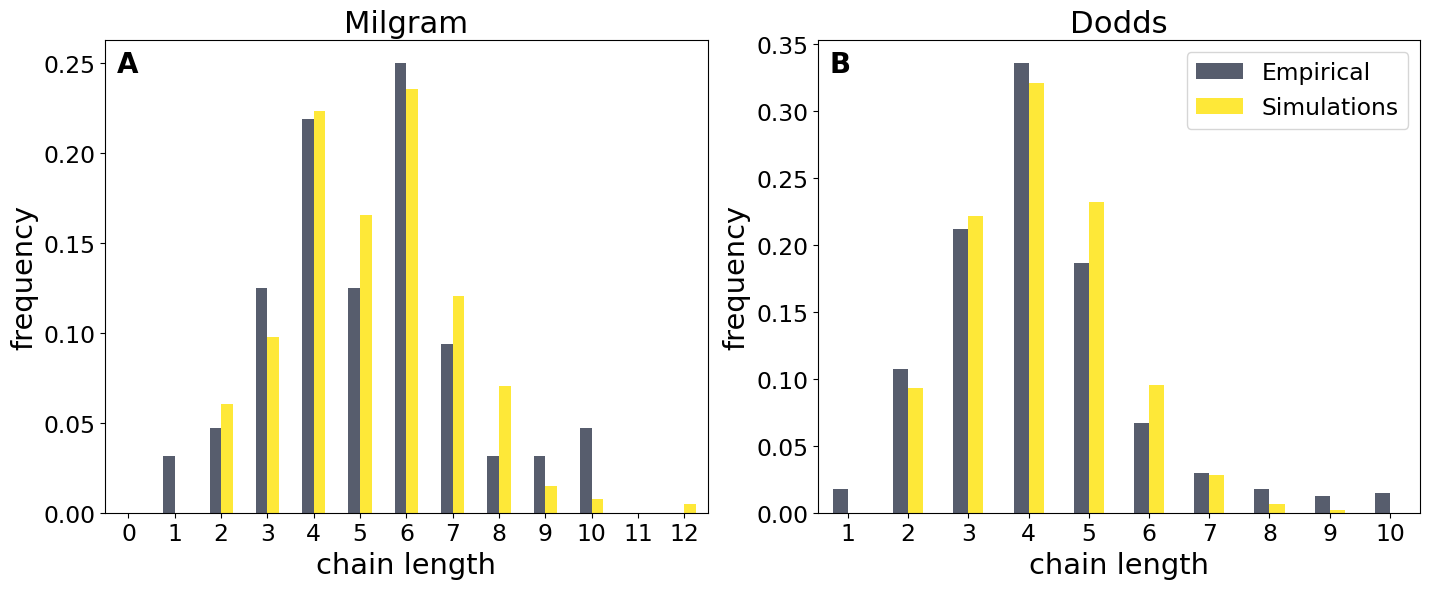

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(1.8*figsize[0], figsize[1]))
colors = plt.get_cmap('cividis', 4).colors[1::2]
# colors = np.array(cs)[[5,3]]

# ========== PLOT 1 (Milgram) ==========
df_milgram.plot(kind='bar', color=colors, ax=ax[0],
                xlabel='chain length', ylabel='frequency', title='Milgram', legend=False)
ax[0].tick_params(axis='x', labelrotation=0)

# ========== PLOT 2 (Dodds) ==========
df_dodds.plot(kind='bar', color=colors, ax=ax[1],
                xlabel='chain length', ylabel='frequency', title='Dodds')
ax[1].tick_params(axis='x', labelrotation=0)
ax[1].legend(fontsize=legend_font_size)

## Add panel labels
label_panels(ax, pos=(0.02, 0.98))
plt.tight_layout();

## Save 
if SAVE:
    fn = f'empirical_chain_length_distribution.png'
    fn = os.path.join(path_save, fn)
    plt.savefig(fn, format='png', dpi=300, bbox_inches='tight')
    print(f"Plot saved successfully at {fn}")

# Figure 7
Empirical networks

In [22]:
# read
path = os.path.join( PATH, 'heterogeneous', 'pr_vs_requirements', 'real_network' )
path_oracle = os.path.join( PATH, 'heterogeneous', 'pr_vs_requirements', 'real_network_oracle' )
results = dict()
results_oracle = dict()
for network_name in REAL_NETWORK_SELECTION:
    # name
    network_name = network_name.replace('/','-')        
    # read
    path_ = os.path.join(path, network_name )
    path_oracle_ = os.path.join(path_oracle, network_name )
    results[network_name], p_recs, vacancy_requirements = read_results(path_)
    results_oracle[network_name], p_recs, vacancy_requirements = read_results(path_oracle_)

# save params
path_save = os.path.join( PATH_SAVE, 'heterogeneous', 'pr_vs_requirements', 'real_network' )
path_save_oracle = os.path.join( PATH_SAVE, 'heterogeneous', 'pr_vs_requirements', 'real_network_oracle' )
os.makedirs(path_save, exist_ok=True)
os.makedirs(path_save_oracle, exist_ok=True)

print("Read successfully!")

Read successfully!


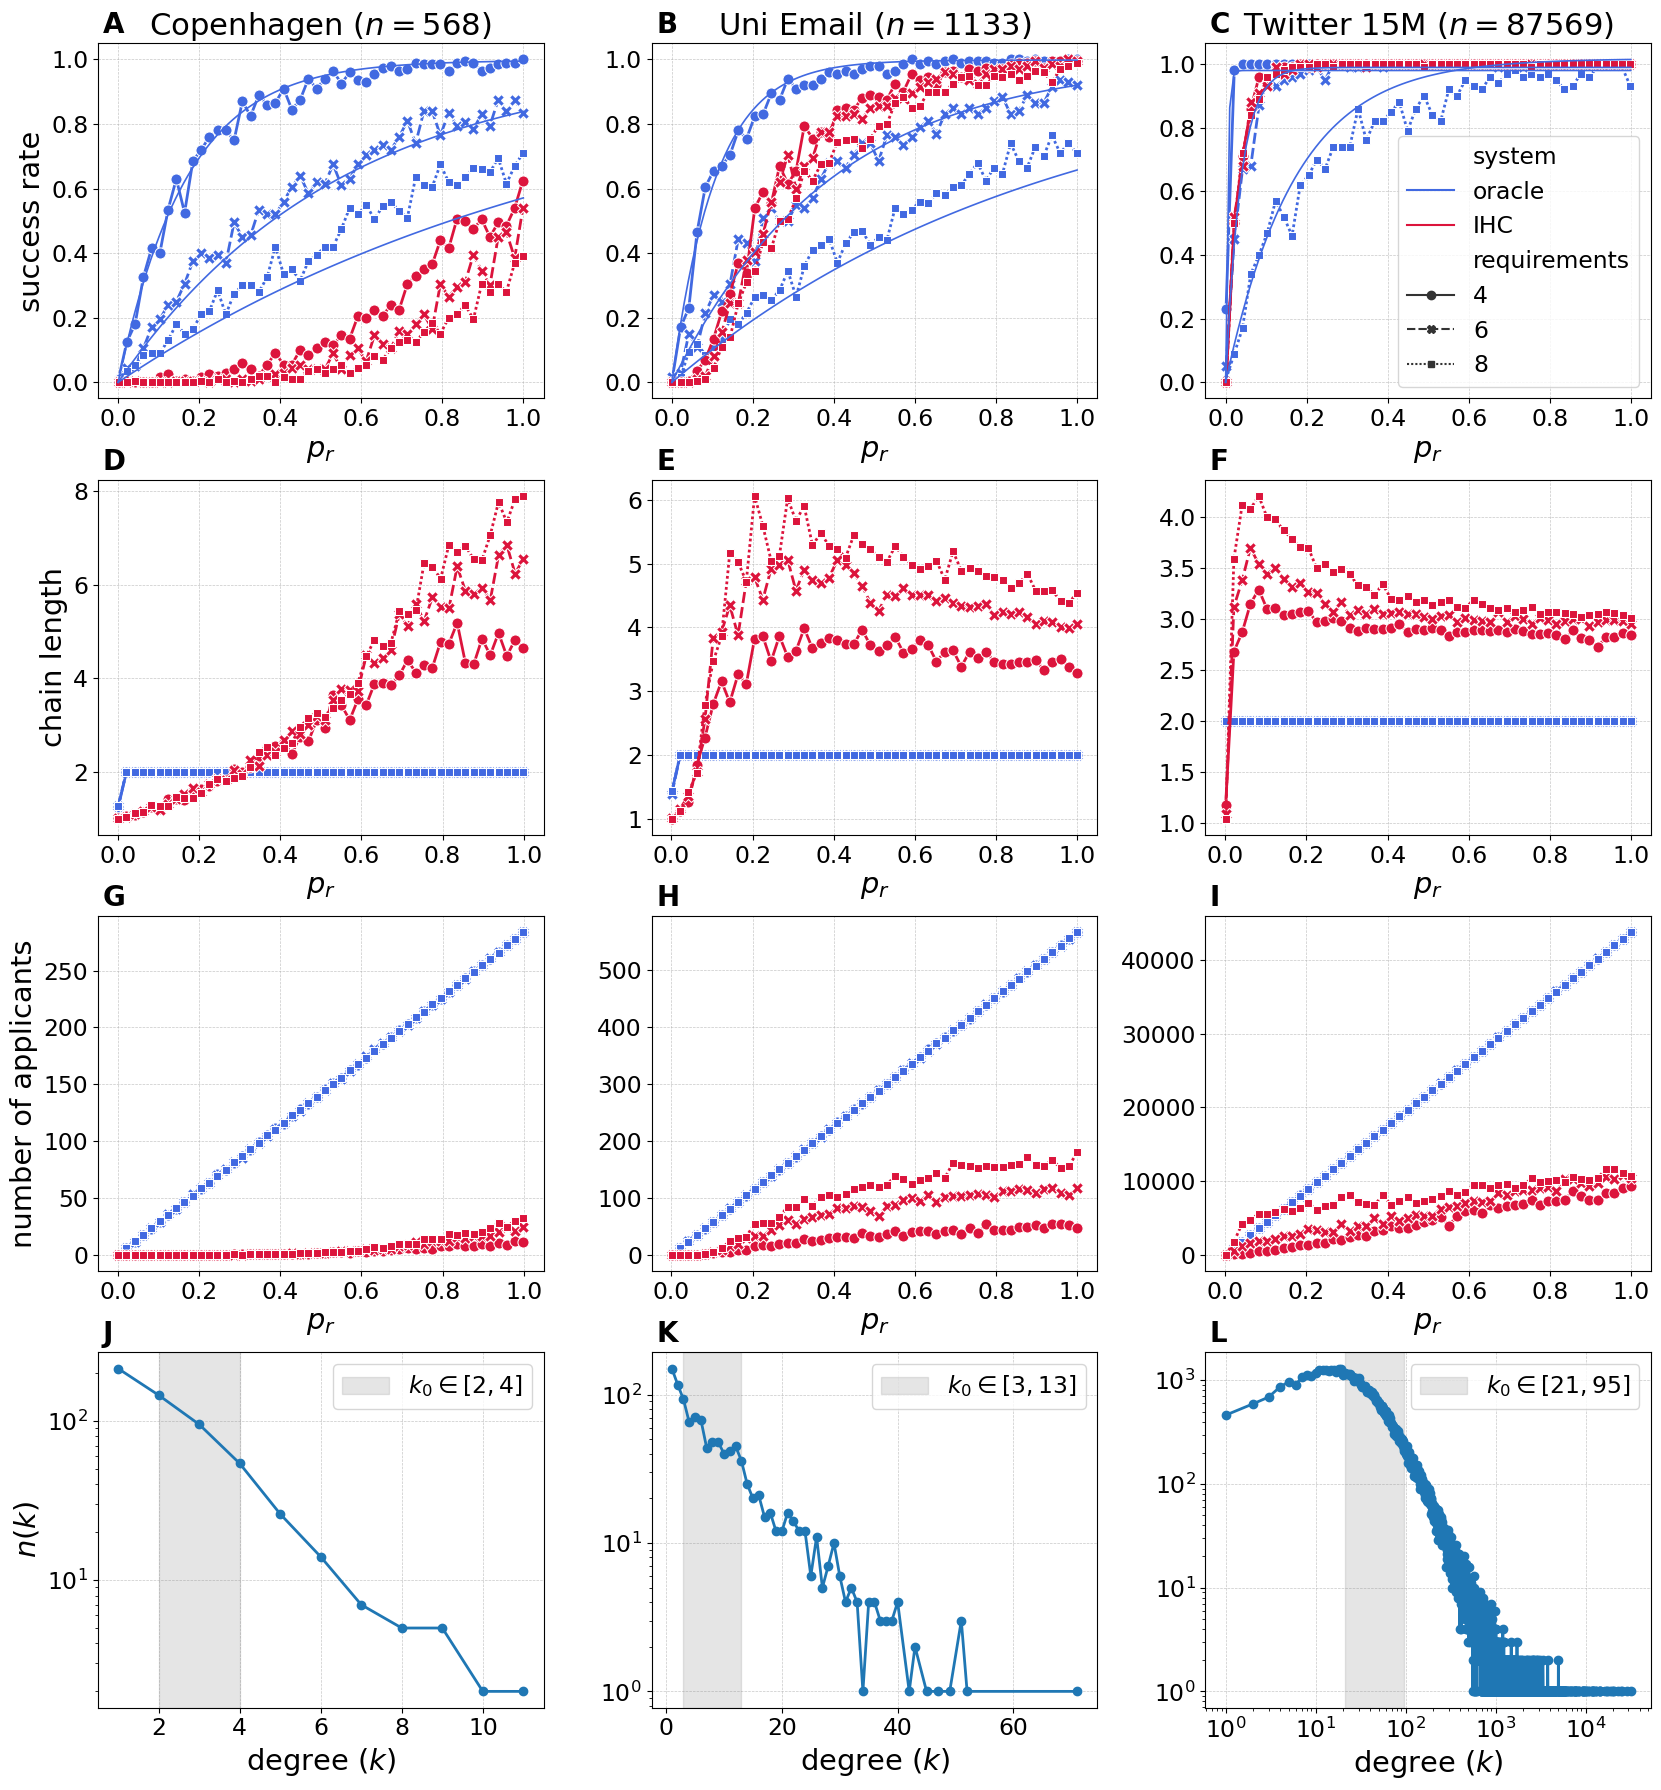

In [23]:
# global plot params
fig, axes = plt.subplots(4, 3, figsize=(2.1*figsize[0], 3*figsize[1]),
                         sharex=False, sharey=False)
 
for col, name in enumerate(REAL_NETWORK_SELECTION):
    ax = axes[:,col]
    name = name.replace('/','-')    
    
    ### Prepare data ###
    success    = np.mean(results[name]['success_rate'], axis=1).reshape( len(p_recs), len(vacancy_requirements) )
    applicants = np.mean(results[name]['applicants'], axis=1).reshape( len(p_recs), len(vacancy_requirements) )
    depths     = np.mean(results[name]['chain_depths'], axis=1).reshape( len(p_recs), len(vacancy_requirements) )
    success_oracle    = np.mean(results_oracle[name]['success_rate'], axis=1).reshape( len(p_recs), len(vacancy_requirements) )
    applicants_oracle = np.mean(results_oracle[name]['applicants'], axis=1).reshape( len(p_recs), len(vacancy_requirements) )
    depths_oracle     = np.mean(results_oracle[name]['chain_depths'], axis=1).reshape( len(p_recs), len(vacancy_requirements) )
    ## Convert to long dataframe
    # success rate
    df_success_ihc = results_to_dataframe(success, x=p_recs, system='IHC')
    df_success_oracle = results_to_dataframe(success_oracle, x=p_recs, system='oracle')
    df_success = pd.concat([df_success_oracle, df_success_ihc], ignore_index=True)
    # applicants
    df_applicants_ihc = results_to_dataframe(applicants, x=p_recs, system='IHC')
    df_applicants_oracle = results_to_dataframe(applicants_oracle, x=p_recs, system='oracle')
    df_applicants = pd.concat([df_applicants_oracle, df_applicants_ihc], ignore_index=True)
    # chain depth
    df_depths_ihc = results_to_dataframe(depths, x=p_recs, system='IHC')
    df_depths_oracle = results_to_dataframe(depths_oracle, x=p_recs, system='oracle')
    df_depths = pd.concat([df_depths_oracle, df_depths_ihc], ignore_index=True)
    ## Theoretical predictions
    prs_theo, success_theo = oracle_theoretical_success_rate(-1, network_name=name)
    ## Degree sequence
    edgelist, nodelist = import_graphtool_network(name.replace('-','/'))
    degrees = edgelist.groupby('source').size()
    k_min = round( max(2, degrees.quantile(0.25)) )
    k_max = round( max(k_min+2, degrees.quantile(0.75)) )
    k0_range = [k_min, k_max]

    ### Viz ###
    # ========== PLOT 1 (success rate) ==========        
    sns.lineplot(
        data=df_success, x="$p_r$", y='y', hue="system", style="requirements", 
        markers=True, dashes=True, palette=cs[:2], lw=2, ms=8, ax=ax[0], legend=(col == 2))
    ax[0].plot(prs_theo, success_theo, color=cs[0], lw=1.2)

    ax[0].set_title(f"{name.replace('-sms','').replace('_',' ').title()} ($n={len(nodelist)}$)")
    ax[0].set_ylabel(None)
    ax[0].grid(True)
    if col == 2:
        ax[0].legend(loc='lower right')

    # ========== PLOT 2 (chain length) ==========        
    sns.lineplot(
        data=df_depths, x="$p_r$", y='y', hue="system", style="requirements", 
        markers=True, dashes=True, palette=cs[:2], lw=2, ms=8, ax=ax[1], legend=False)
        
    ax[1].set_ylabel(None)
    ax[1].grid(True)
    
    # ========== PLOT 3 (applicants) ==========        
    sns.lineplot(
        data=df_applicants, x="$p_r$", y='y', hue="system", style="requirements", 
        markers=True, dashes=True, palette=cs[:2], lw=2, ms=8, ax=ax[2], legend=False)
    
    ax[2].set_ylabel(None)
    ax[2].grid(True)    

    # ========== PLOT 4 (degree distribution) ==========        
    degrees.value_counts(normalize=False).sort_index().plot(marker='o', ms=6, ax=ax[3], lw=2, label="", legend=False)
    ax[3].axvspan( *k0_range, alpha=0.2, color='gray', label=f"$k_0 \\in {k0_range}$" )
        
    ax[3].set_xlabel("degree ($k$)")    
    ax[3].grid(True)
    ax[3].legend(loc='upper right')
    ax[3].set_yscale('log')
    if col == 2:        
        ax[3].set_xscale('log')    

# label axes and titles
axes[0,0].set_ylabel('success rate')
axes[1,0].set_ylabel('chain length')
axes[2,0].set_ylabel('number of applicants')
axes[3,0].set_ylabel("$n(k)$")
plt.tight_layout()

## Add panel labels
label_panels(axes, pos=(0.01, 1.09))

if SAVE:    
    sample_path = glob(os.path.join(path_, 'chain_depths', '*.npy'))[0]
    avg_skills = extract_param_from_path(sample_path, 'avg_skills')    
    fn = f'real_networks_panel-avg_skills={avg_skills}.png'
    fn = os.path.join(path_save, fn)
    plt.savefig(fn, format='png', dpi=300, bbox_inches='tight')
    print(f"Plot saved successfully at {fn}")

# Appendix Figure 1
Homophilic networks and skills correlations

A bit dirtier; it doesn't come from saved simulations

In [134]:
# helpers
import networkx as nx
from skills_and_vacancies import sample_skills_correlated, majority_groups, onehot_encode_skills
from utils.plotter import detect_communities, visualize_communities
from network_generators.homophilic import generate_homophilic_network_edgelist

def skill_correlation(X: np.ndarray):
    """
    Compute skill-skill correlation matrix by one-hot encoding skills data.
    Rows: subjects, Cols: skills.
    """    
    return np.corrcoef( onehot_encode_skills(X), rowvar=False)

def visualize_homophilic_network(skills, k_avg=K_AVG, homophily=HOMOPHILY, n_skill_groups=N_SKILL_GROUPS):
    """Creates homophilic network and visualizes it colored by agents skill groups.
    """
    # Sample homophilic edgelist
    edgelist = generate_homophilic_network_edgelist(skills, k_avg, homophily)
    
    # Create networkx graph (and extract lcc for better viz)
    G = nx.from_pandas_edgelist(edgelist, create_using=nx.Graph)
    G = G.subgraph(max(nx.connected_components(G), key=len))
    
    # Label nodes according to their skills majority group
    mg = majority_groups(skills, n_skill_groups )
    node_to_comm = {i:g for i,g in enumerate(mg)}
    
    # Viz
    visualize_communities(G, node_to_comm)

In [138]:
# Read: generate correlated skills in-situ
np.random.seed(42)
n_skills = 12
skills = sample_skills_correlated(N, AVG_SKILLS, N_SKILL_GROUPS, ALPHA, n_skills=n_skills)

# Save path
path_save = os.path.join( PATH_SAVE, 'other', 'homophily' )
os.makedirs(path_save, exist_ok=True)

Plot saved successfully at ../results/figures/other/homophily/skill_correlations-n_nodes=2000-n_skill_groups=3-n_skills=12-alpha=0.5-avg_skills=3.png


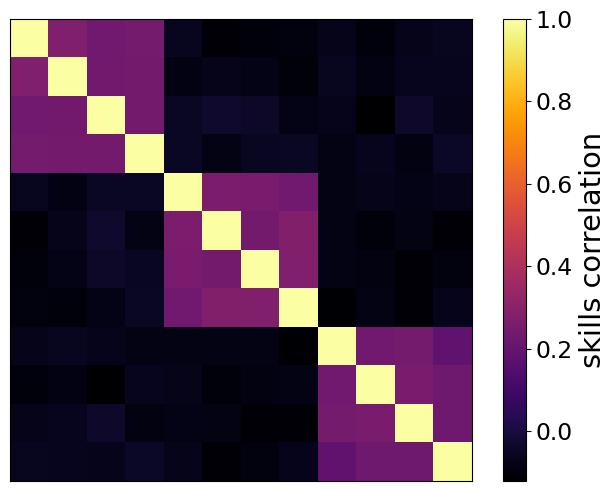

In [139]:
## Correlations
plt.figure(figsize=figsize)
plt.imshow( skill_correlation(skills), cmap="inferno" )
cbar = plt.colorbar()
cbar.set_label('skills correlation')
plt.xticks([] * n_skills);
plt.yticks([] * n_skills);

if SAVE:        
    fn = f'skill_correlations-n_nodes={N}-n_skill_groups={N_SKILL_GROUPS}-n_skills={n_skills}-alpha={ALPHA}-avg_skills={AVG_SKILLS}.png'
    fn = os.path.join(path_save, fn)
    plt.savefig(fn, format='png', dpi=300, bbox_inches='tight')
    print(f"Plot saved successfully at {fn}")

Plot saved successfully at ../results/figures/other/homophily/network-n_nodes=2000-n_skill_groups=3-n_skills=12-alpha=0.5-avg_skills=3-homophily=2.png
Plot saved successfully at ../results/figures/other/homophily/network-n_nodes=2000-n_skill_groups=3-n_skills=12-alpha=0.5-avg_skills=3-homophily=4.png
Plot saved successfully at ../results/figures/other/homophily/network-n_nodes=2000-n_skill_groups=3-n_skills=12-alpha=0.5-avg_skills=3-homophily=6.png
Plot saved successfully at ../results/figures/other/homophily/network-n_nodes=2000-n_skill_groups=3-n_skills=12-alpha=0.5-avg_skills=3-homophily=8.png


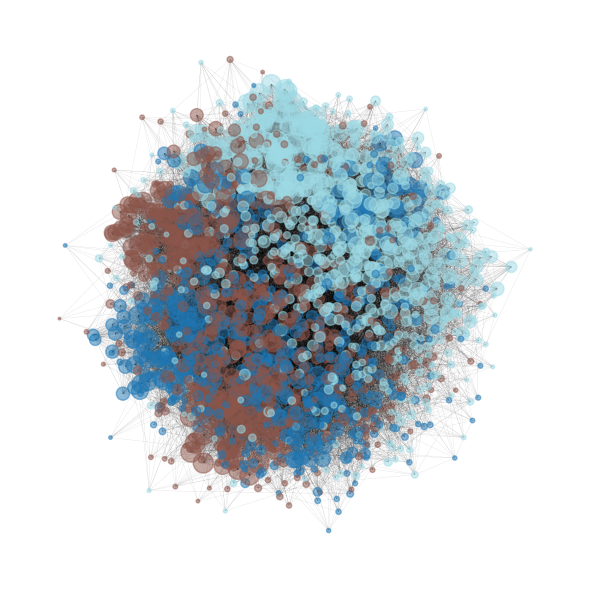

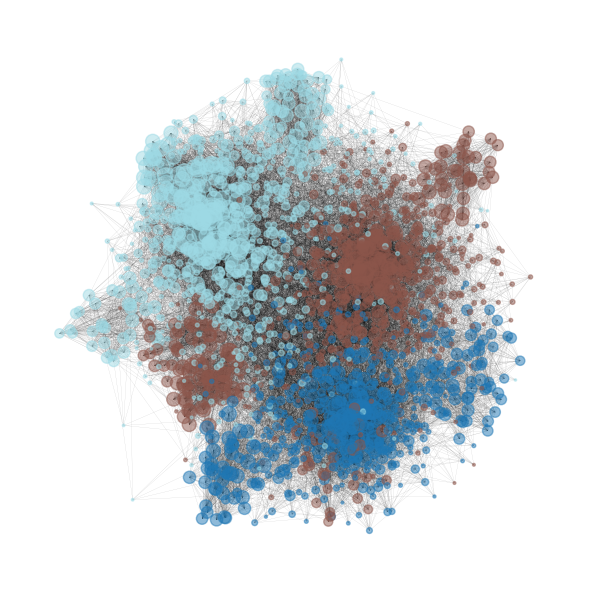

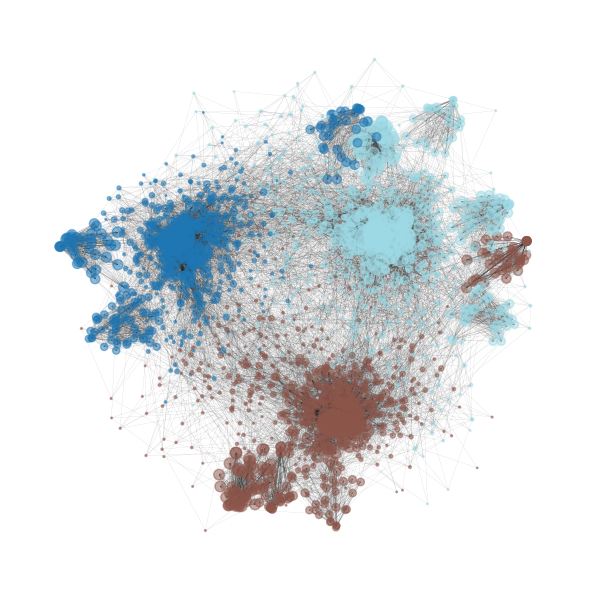

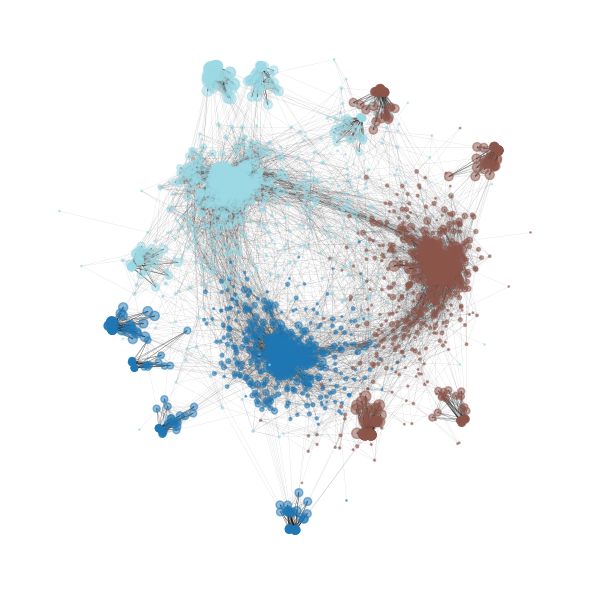

In [144]:
## Networks
homophilies = [2,4,6,8]
for h in homophilies:
    visualize_homophilic_network(skills, homophily=h)

    if SAVE:
        fn = f'network-n_nodes={N}-n_skill_groups={N_SKILL_GROUPS}-n_skills={n_skills}-alpha={alpha}-avg_skills={AVG_SKILLS}-homophily={h}.png'
        fn = os.path.join(path_save, fn)
        plt.savefig(fn, format='png', dpi=200, bbox_inches='tight')
        print(f"Plot saved successfully at {fn}")